# Spatially varying parameters 2

In this notebook, one data point from Figure 2 in [Beg *et al.* Stable and manipulable Bloch point. *Scientific Reports*, **9**, 7959 (2019)](https://doi.org/10.1038/s41598-019-44462-2) is simulated.

We need to relax a $150 \,\text{nm}$ disk, which consists of two layers with different sign of Dzyaloshinskii-Moriya constant $D$. The bottom layer with $D<0$ has $20 \,\text{nm}$ thickness, whereas the top layer with $D>0$ has $10 \,\text{nm}$ thickness. We start by importing the necessary modules and creating the mesh with two regions.

In [1]:
import oommfc as mc
import discretisedfield as df
import micromagneticmodel as mm

d = 150e-9
hb = 20e-9
ht = 10e-9
cell = (5e-9, 5e-9, 2.5e-9)
subregions = {'r1': df.Region(p1=(-d/2, -d/2, -hb), p2=(d/2, d/2, 0)),
              'r2': df.Region(p1=(-d/2, -d/2, 0), p2=(d/2, d/2, ht))}
p1 = (-d/2, -d/2, -hb)
p2 = (d/2, d/2, ht)
mesh = df.Mesh(p1=p1, p2=p2, cell=cell, subregions=subregions)

The mesh domain and the discretisation cells are:

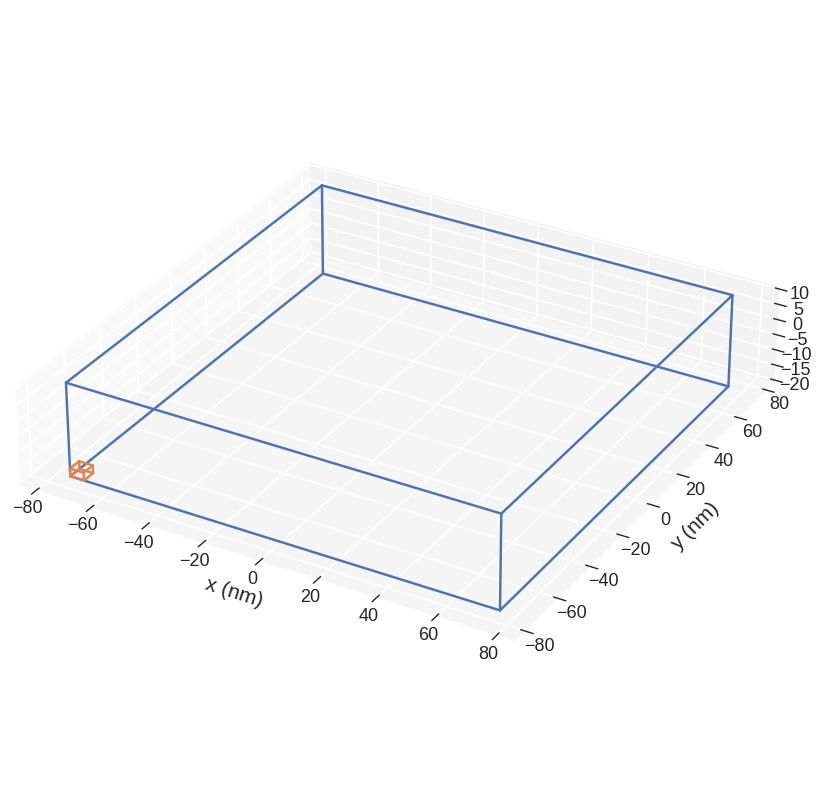

In [2]:
mesh.mpl(figsize=(10, 10))

and the two regions we defined are:

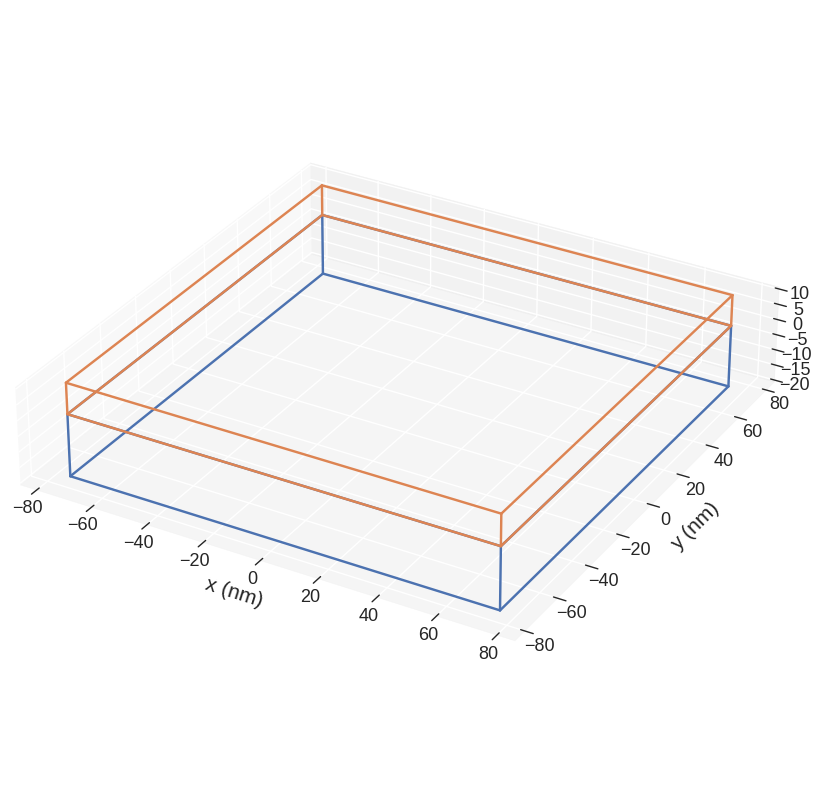

In [3]:
mesh.mpl.subregions(figsize=(10, 10))

Now, we need to define the system object, and by setting magnetisation saturation, set the geometry to be a disk.

In [4]:
system = mm.System(name='bloch_point')

D = {'r1': 1.58e-3, 'r2': -1.58e-3, 'r1:r2': 1.58e-9}
Ms = 3.84e5
A = 8.78e-12

def Ms_fun(point):
    x, y, z = point
    if x**2 + y**2 <= (d/2)**2:
        return Ms
    else:
        return 0

system.energy = mm.Exchange(A=A) + mm.DMI(D=D, crystalclass='T') + mm.Demag()
system.m = df.Field(mesh, nvdim=3, value=(0, 0, 1), norm=Ms_fun, valid="norm")

Our sample is now:

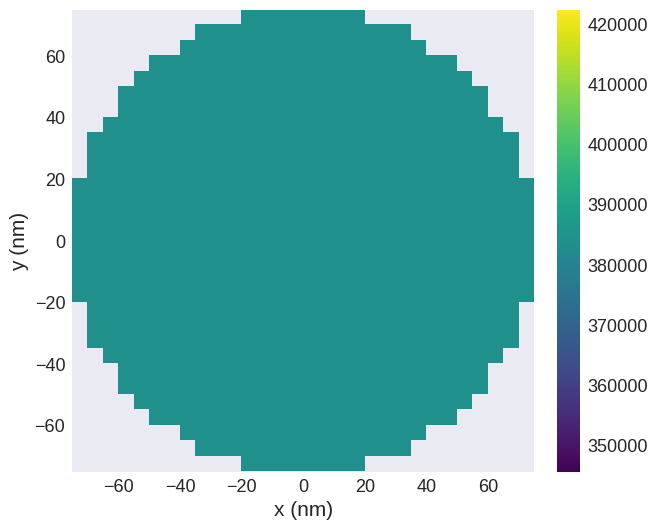

In [5]:
system.m.norm.sel("z").mpl()

Now, we can minimise the system's energy by using `MinDriver`.

In [6]:
md = mc.MinDriver()
md.drive(system)

Running OOMMF (ExeOOMMFRunner)[2023/10/23 16:07]... (0.8 s)


The out-of-plane magnetisation component ($m_{z}$) is now:

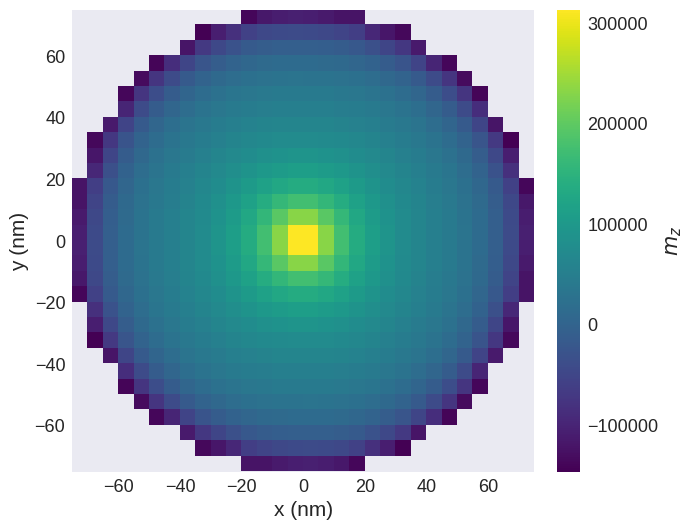

In [7]:
system.m.z.sel("z").mpl(scalar_kw={"colorbar_label": "$m_z$"})

We can see that two vortices with different orientation emerged. We can inspect this closer by plotting an `hv` plot of the magnetisation as follows:

In [8]:
system.m.hv(kdims=["x", "y"])

:DynamicMap   [z]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

The slider can be utilized to view magnetisation configuration at different `z` values.
We can now plot another cross section and see that the Bloch point emerged.

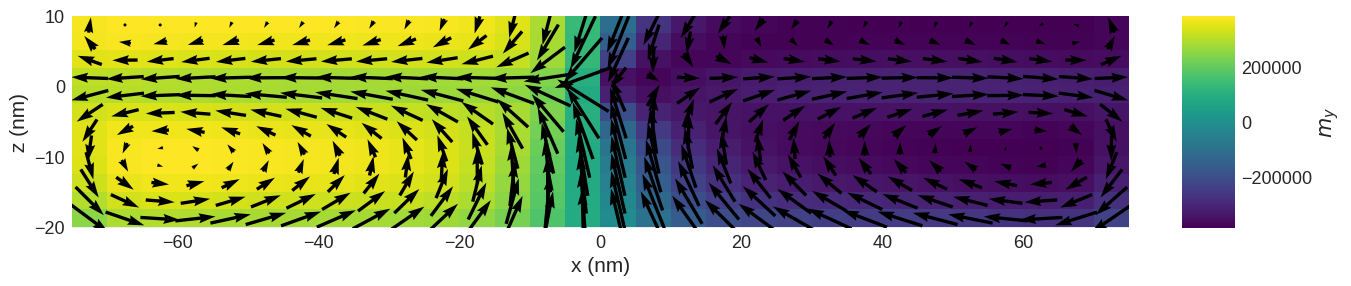

In [9]:
system.m.sel("y").mpl(scalar_kw={"colorbar_label": "$m_y$"}, figsize=(15, 10))